# Prototype 2 results



In [114]:
import pandas as pd
import numpy as np
import gtfparse
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [85]:
def load_gene_expr(version):
    
    gtf = gtfparse.read_gtf(f"../../reference/Homo_sapiens.GRCh38.{version}.chr1.gtf.gz")
    chr1_genes = [g['gene_id'] for g in gtf.filter(pl.col("feature") == "gene").iter_rows(named=True)]
    
    samples = ["Control_siRNA", "STAT5A_siRNA", "STAT5B_siRNA"]
    replicas = ["1", "2", "3"]
    dfs = []
    for s in samples:
        for r in replicas:
            tmp_df =  pd.read_csv(f'../../kallisto_results/v{version}/{s}_{r}/gene_expr.csv', sep=";")
            tmp_df["treatment"] = s
            tmp_df["replicate"] = r
            dfs.append(tmp_df[tmp_df.gene_id.isin(chr1_genes)])
            
    df = pd.concat(dfs)
    
    # print number of rows
    print(f"Number of rows: {df.shape[0]}")
    
    return df

In [81]:
gtf = gtfparse.parse_gtf(f"../../reference/Homo_sapiens.GRCh38.86.chr1.gtf.gz")

In [83]:
gtf.columns

['seqname',
 'source',
 'feature',
 'start',
 'end',
 'score',
 'strand',
 'frame',
 'attribute',
 'attribute_split']

In [86]:
df_109 = load_gene_expr(version="109")
df_109.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level']


Number of rows: 30249


,gene_id,gene_symbol,avg_len,count,rpkm,tpm,treatment,replicate
3,ENSG00000000457,SCYL3,3113.890000,294,17.096702,24.603750,Control_siRNA,1
4,ENSG00000000460,C1orf112,2359.200667,137,10.549832,9.957120,Control_siRNA,1
5,ENSG00000000938,FGR,1650.232571,10109,1110.378277,1157.489000,Control_siRNA,1
6,ENSG00000000971,CFH,2892.218154,87,5.474013,10.179316,Control_siRNA,1
10,ENSG00000001460,STPG1,1612.589417,122,13.726298,11.337379,Control_siRNA,1


In [87]:
df_86 = load_gene_expr(version="86")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


Number of rows: 29502


In [88]:
df_108 = load_gene_expr(version="108")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level']


Number of rows: 30249


In [38]:
def load_identical_genes(version1, version2):
    df = pd.read_csv(f'../output/{version1}.vs.{version2}.csv')
    identical_genes_different_id = df[df.gene_id_1 != df.gene_id_2].shape[0]
    print(f"Number of identical genes with different ids: {identical_genes_different_id}")
    return df

In [39]:
df_109_vs_86 = load_identical_genes(version1="109", version2="86")
df_109_vs_86.head()

Number of identical genes with different ids: 13


,gene_id_1,gene_id_2
0,ENSG00000228037,ENSG00000228037
1,ENSG00000269896,ENSG00000269896
2,ENSG00000260972,ENSG00000260972
3,ENSG00000224340,ENSG00000224340
4,ENSG00000229280,ENSG00000229280


In [40]:
df_109_vs_108 = load_identical_genes(version1="109", version2="108")
df_109_vs_108.head()

Number of identical genes with different ids: 0


,gene_id_1,gene_id_2
0,ENSG00000160072,ENSG00000160072
1,ENSG00000279928,ENSG00000279928
2,ENSG00000228037,ENSG00000228037
3,ENSG00000142611,ENSG00000142611
4,ENSG00000284616,ENSG00000284616


## Compare results

In [141]:
def compare_results(df1, df2, identical_genes, suffix1="_1", suffix2="_2"):
    
    merged_df = pd.merge(df1, df2, on=['gene_id', 'treatment', 'replicate'], suffixes=(suffix1, suffix2), how='inner')

    correlations_before = calculate_tpm_correlation(merged_df, suffix1, suffix2)
    calculate_jaccard(df1, df2, merged_df)

    merged_df_2 = None
    if identical_genes is not None:
        df1_with_gene_id_2 = pd.merge(df1, identical_genes, left_on='gene_id', right_on='gene_id_1',  how='inner')
        merged_df_2 = pd.merge(df1_with_gene_id_2, df2, left_on=['gene_id_2', 'treatment', 'replicate'], 
                               right_on=['gene_id', 'treatment', 'replicate'], suffixes=(suffix1, suffix2), how='inner')
        
        correlations_after = calculate_tpm_correlation(merged_df_2, suffix1, suffix2, gene_column=f"gene_id{suffix1}")
        calculate_jaccard(df1, df2, merged_df_2, gene_column=f"gene_id{suffix1}")
        
    # print median correlation
    print(f"Median correlation before: {np.median(correlations_before)}")
    print(f"Median correlation after: {np.median(correlations_after)}")
    
    return merged_df, merged_df_2, correlations_before, correlations_after


def calculate_jaccard(df1, df2, merged_df, gene_column="gene_id"):
    shared_genes = len(merged_df[gene_column].unique())
    print(f"Number of shared genes: {shared_genes}")
    unique_1 = len(df1.gene_id.unique()) - shared_genes
    unique_2 = len(df2.gene_id.unique()) - shared_genes
    print(f"Number of unique genes in df1: {unique_1}")
    print(f"Number of unique genes in df2: {unique_2}")
    jaccard = shared_genes / (shared_genes + unique_1 + unique_2)
    print(f"Jaccard coefficient: {jaccard}")
    return jaccard


def calculate_tpm_correlation(merged_df, suffix1, suffix2, gene_column="gene_id"):
    correlations = []
    for g in merged_df[gene_column].unique():
        gene_merged_df = merged_df[merged_df[gene_column] == g]
        corrcoef = np.corrcoef(gene_merged_df['tpm' + suffix1], gene_merged_df['tpm' + suffix2])[0, 1]
        if not np.isnan(corrcoef):
            correlations.append(corrcoef)
    return correlations


In [142]:
control1_109_vs_86, control1_109_vs_86_2, corr_before, corr_after = compare_results(
    df1=df_109, df2=df_86, suffix1="_109", suffix2="_86", identical_genes=df_109_vs_86)

/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Number of shared genes: 3219
Number of unique genes in df1: 142
Number of unique genes in df2: 59
Jaccard coefficient: 0.9412280701754386


/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Number of shared genes: 1235
Number of unique genes in df1: 2126
Number of unique genes in df2: 2043
Jaccard coefficient: 0.22853441894892673
Median correlation before: 0.9990092326016159
Median correlation after: 0.999999178803036


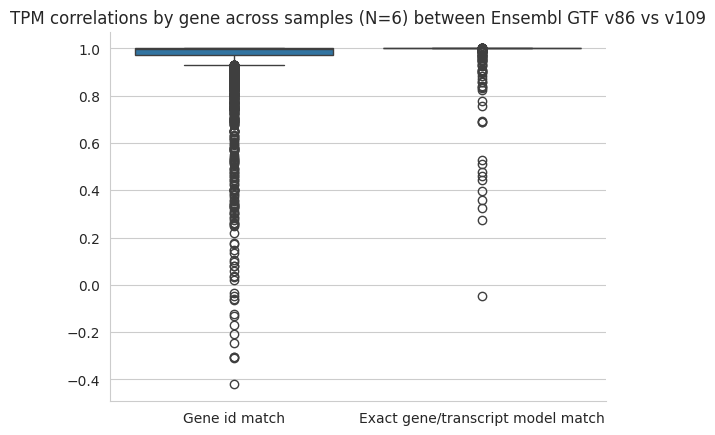

In [139]:
df_correlations_before = pd.DataFrame({'correlations':corr_before})
df_correlations_before["method"] = "Gene id match"
df_correlations_after = pd.DataFrame({'correlations':corr_after})
df_correlations_after["method"] = "Exact gene/transcript model match"
df_correlations = pd.concat([df_correlations_before, df_correlations_after])

sns.boxplot(data=df_correlations.reset_index(), x='method', y='correlations', hue='method')
# log transform x axis
#plt.yscale('log')
plt.xlabel(None)
plt.ylabel(None)
plt.title("TPM correlations by gene across samples (N=6) between Ensembl GTF v86 vs v109")
sns.despine()

In [143]:
control1_109_vs_86, control1_108_vs_86_2, corr_before, corr_after = compare_results(
    df1=df_109, df2=df_108, suffix1="_109", suffix2="_108", identical_genes=df_109_vs_108)

/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Number of shared genes: 3361
Number of unique genes in df1: 0
Number of unique genes in df2: 0
Jaccard coefficient: 1.0


/home/priesgo/src/curahack/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Number of shared genes: 3347
Number of unique genes in df1: 14
Number of unique genes in df2: 14
Jaccard coefficient: 0.9917037037037038
Median correlation before: 0.9999999965588872
Median correlation after: 0.9999999966047652


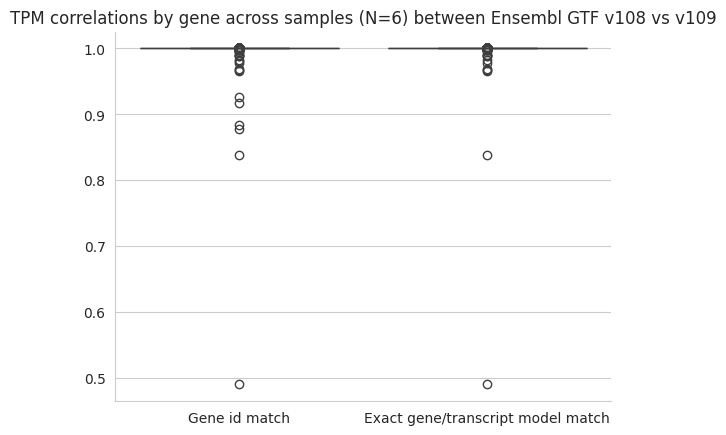

In [126]:
df_correlations_before = pd.DataFrame({'correlations':corr_before})
df_correlations_before["method"] = "Gene id match"
df_correlations_after = pd.DataFrame({'correlations':corr_after})
df_correlations_after["method"] = "Exact gene/transcript model match"
df_correlations = pd.concat([df_correlations_before, df_correlations_after])

sns.boxplot(data=df_correlations.reset_index(), x='method', y='correlations', hue='method')
# log transform x axis
#plt.yscale('log')
plt.xlabel(None)
plt.ylabel(None)
plt.title("TPM correlations by gene across samples (N=6) between Ensembl GTF v108 vs v109")
sns.despine()

In [61]:
len(control1_109_vs_86.gene_id.unique())

34390

In [62]:
len(df_109.gene_id.unique())

35658

In [50]:
control1_109_vs_86_2.head()

,gene_id_109,gene_symbol_109,avg_len_109,count_109,rpkm_109,tpm_109,treatment_109,replicate_109,gene_id_1,gene_id_2,gene_id_86,gene_symbol_86,avg_len_86,count_86,rpkm_86,tpm_86,treatment_86,replicate_86
0,ENSG00000008130,NADK,1128.795118,12445,1998.432734,1385.53875,Control_siRNA,1,ENSG00000008130,ENSG00000008130,ENSG00000008130,NADK,1128.795118,12445,1998.433023,1393.94722,Control_siRNA,1
1,ENSG00000008130,NADK,1128.795118,12445,1998.432734,1385.53875,Control_siRNA,1,ENSG00000008130,ENSG00000008130,ENSG00000008130,NADK,1128.795882,9655,1949.244722,1427.37100,Control_siRNA,2
2,ENSG00000008130,NADK,1128.795118,12445,1998.432734,1385.53875,Control_siRNA,1,ENSG00000008130,ENSG00000008130,ENSG00000008130,NADK,1128.795882,11352,1915.690916,1416.93483,Control_siRNA,3
3,ENSG00000008130,NADK,1128.795118,12445,1998.432734,1385.53875,Control_siRNA,1,ENSG00000008130,ENSG00000008130,ENSG00000008130,NADK,1128.792824,14425,2257.191845,1808.24930,STAT5A_siRNA,1
4,ENSG00000008130,NADK,1128.795118,12445,1998.432734,1385.53875,Control_siRNA,1,ENSG00000008130,ENSG00000008130,ENSG00000008130,NADK,1128.792059,13847,2227.900937,1847.57623,STAT5A_siRNA,2


In [35]:
control1_109_vs_108 = compare_results(df1=df_109, df2=df_108, suffix1="_109", suffix2="_86")

Number of shared genes: 35644
Number of unique genes in df1: 14
Number of unique genes in df2: 2
TPM correlation coefficient: 0.9999998068047933
Jaccard coefficient: 0.9995513180033652
